# How to create a sequence of steps

!!! info "Prerequisites"
    This guide assumes familiarity with the following:

    - [How to define and update graph state](../../how-tos/state-reducers)

This guide demonstrates how to construct a simple sequence of steps. We will demonstrate:

1. How to build a sequential graph
2. Built-in short-hand for constructing similar graphs.


# Summary

To add a sequence of nodes, we use the `.add_node` and `.add_edge` methods of our [graph](../../concepts/low_level/#stategraph):
```python
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node(step_1)
graph_builder.add_node(step_2)
graph_builder.add_node(step_3)

# Add edges
graph_builder.add_edge(START, "step_1")
graph_builder.add_edge("step_1", "step_2")
graph_builder.add_edge("step_2", "step_3")
```

We can also use the built-in shorthand `.add_sequence`:
```python
graph_builder = StateGraph(State).add_sequence([step_1, step_2, step_3])
graph_builder.add_edge(START, "step_1")
```


<details>
<summary>Why split application steps into a sequence with LangGraph?</summary>

LangGraph makes it easy to add an underlying persistence layer to your application.
This allows state to be checkpointed in between the execution of nodes, so your LangGraph nodes govern:

<ul>
<li>How state updates are [checkpointed](../../concepts/persistence/)</li>
<li>How interruptions are resumed in [human-in-the-loop](../../concepts/human_in_the_loop/) workflows</li>
<li>How we can "rewind" and branch-off executions using LangGraph's [time travel](../../concepts/time-travel/) features</li>
</ul>

They also determine how execution steps are [streamed](../../concepts/streaming/), and how your application is visualized
and debugged using [LangGraph Studio](../../concepts/langgraph_studio/).

</details>

## Setup

First, let's install langgraph:

In [1]:
%%capture --no-stderr
%pip install -U langgraph

<div class="admonition tip">
     <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for better debugging</p>
     <p style="padding-top: 5px;">
         Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM aps built with LangGraph — read more about how to get started in the <a href="https://docs.smith.langchain.com">docs</a>. 
     </p>
 </div>

## Build the graph

Let's demonstrate a simple usage example. We will create a sequence of three steps:

1. Populate a value in a key of the state
2. Update the same value
3. Populate a different value

### Define state

Let's first define our [state](../../concepts/low_level/#state). This governs the [schema of the graph](../../concepts/low_level/#schema), and can also specify how to apply updates. See [this guide](../../how-tos/state-reducers) for more detail.

In our case, we will just keep track of two values:

In [1]:
from typing_extensions import TypedDict


class State(TypedDict):
    value_1: str
    value_2: int

### Define nodes

Our [nodes](../../concepts/low_level/#nodes) are just Python functions that read our graph's state and make updates to it. The first argument to this function will always be the state:

In [2]:
def step_1(state: State):
    return {"value_1": "a"}


def step_2(state: State):
    current_value_1 = state["value_1"]
    return {"value_1": f"{current_value_1} b"}


def step_3(state: State):
    return {"value_2": 10}

!!! note

    Note that when issuing updates to the state, each node can just specify the value of the key it wishes to update.

By default, this will **overwrite** the value of the corresponding key. You can also use [reducers](../../concepts/low_level/#reducers) to control how updates are processed— for example, you can append successive updates to a key instead. See [this guide](../../how-tos/state-reducers) for more detail.

### Define graph

We use [StateGraph](../../concepts/low_level/#stategraph) to define a graph that operates on this state.

We will then use [add_node](../../concepts/low_level/#messagesstate) and [add_edge](../../concepts/low_level/#edges) to populate our graph and define its control flow.

In [ ]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node(step_1)
graph_builder.add_node(step_2)
graph_builder.add_node(step_3)

# Add edges
graph_builder.add_edge(START, "step_1")
graph_builder.add_edge("step_1", "step_2")
graph_builder.add_edge("step_2", "step_3")

!!! tip "Specifying custom names"

    You can specify custom names for nodes using `.add_node`:

    ```python
    graph_builder.add_node("my_node", step_1)
    ```

Note that:

- `.add_edge` takes the names of nodes, which for functions defaults to `node.__name__`.
- We must specify the entry point of the graph. For this we add an edge with the [START node](../../concepts/low_level/#start-node).
- The graph halts when there are no more nodes to execute.

We next [compile](../../concepts/low_level/#compiling-your-graph) our graph. This provides a few basic checks on the structure of the graph (e.g., identifying orphaned nodes). If we were adding persistence to our application via a [checkpointer](../../concepts/persistence/), it would also be passed in here.

In [4]:
graph = graph_builder.compile()

LangGraph provides built-in utilities for visualizing your graph. Let's inspect our sequence. See [this guide](../../how-tos/visualization) for detail on visualization.

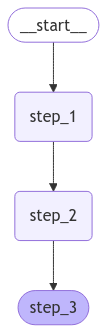

In [5]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Usage

Let's proceed with a simple invocation:

In [6]:
graph.invoke({"value_1": "c"})

{'value_1': 'a b', 'value_2': 10}

Note that:

- We kicked off invocation by providing a value for a single state key. We must always provide a value for at least one key.
- The value we passed in was overwritten by the first node.
- The second node updated the value.
- The third node populated a different value.

## Built-in shorthand

!!! info "Prerequisites"
    `.add_sequence` requires `langgraph>=0.2.46`


LangGraph includes a built-in shorthand `.add_sequence` for convenience:

In [7]:
# highlight-next-line
graph_builder = StateGraph(State).add_sequence([step_1, step_2, step_3])
graph_builder.add_edge(START, "step_1")

graph = graph_builder.compile()

graph.invoke({"value_1": "c"})

{'value_1': 'a b', 'value_2': 10}